Этот ноутбук посвящен классификации персонажей мультсериала Симпсоны

In [ ]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

Перезапустим среду и проверим версию:

In [ ]:
import PIL
PIL.__version__

'5.3.0'

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Подключимся к google-диску для зарузки данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
DATA_MODES = ['train', 'val', 'test']
# масштабируем изображения к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

Напишем класс для датасета с картинками

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == "train":
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip() 
        ])
        else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

Взглянув на датаесет, можно заметить, что некоторые классы содержат очень мало картинок (вплоть до 3). Я самостоятельно увеличил количество изображений в таких классах до ~30, но, конечно, этого все раво мало. Поэтому расклонируем малочисленные классы

In [ ]:
from sklearn.model_selection import train_test_split
from random import shuffle
from itertools import chain

# Разбиваем список категоризированных файлов на часть для тренировки модели и валидации 
train_slice, val_slice  = train_test_split(train_val_files, test_size=0.05,    \
                                            random_state=60, stratify=train_val_labels)

train_slice_labels = [path.parent.name for path in train_slice]
val_slice_labels = [path.parent.name for path in val_slice]


# Анализируем получившуюся разбивку, смотрим на распределение по классам
ALL_LABELS = sorted(set(train_slice_labels))
train_dict = {lbl : [train_slice[i] for i in range(len(train_slice)) if train_slice_labels[i]==lbl] for lbl in ALL_LABELS}
split_dict = {lbl : [train_slice_labels.count(lbl), val_slice_labels.count(lbl)] for lbl in ALL_LABELS}
split_dict = pd.DataFrame(data=split_dict, index=['TestCount', 'ValCount']).T 

# Определяем границу
poverty_line = split_dict['TestCount'].quantile()
display('Poverty line: ', poverty_line)

display(split_dict.describe())

# Клонируем маленькие классы
for lbl in split_dict[split_dict['TestCount']<poverty_line].index:
  train_dict[lbl] *= int(poverty_line // len(train_dict[lbl]) +1)

# Формируем и смешиваем новый список train
train_slice = list(chain.from_iterable(train_dict.values()))
shuffle(train_slice)
train_slice_labels = [path.parent.name for path in train_slice]

# Заново анализируем новую разбивку, проверяем, что теперь элементов достаточное количество
split_dict_new = {lbl : [train_slice_labels.count(lbl), val_slice_labels.count(lbl)] for lbl in ALL_LABELS}
split_dict_new = pd.DataFrame(data=split_dict_new, index=['TestCount_New', 'ValCount_New']).T 
display(split_dict_new.describe())
display(split_dict.merge(split_dict_new, how='left', left_index=True, right_index=True))

'Poverty line: '

147.0

,TestCount,ValCount
count,42.000000,42.000000
mean,475.714286,25.047619
std,546.346548,28.820684
min,26.000000,1.000000
25%,46.750000,2.250000
50%,147.000000,7.500000
75%,919.500000,48.250000
max,2134.000000,112.000000


,TestCount_New,ValCount_New
count,42.000000,42.000000
mean,536.380952,25.047619
std,500.296983,28.820684
min,150.000000,1.000000
25%,172.500000,2.250000
50%,232.000000,7.500000
75%,919.500000,48.250000
max,2134.000000,112.000000


,TestCount,ValCount,TestCount_New,ValCount_New
abraham_grampa_simpson,867,46,867,46
agnes_skinner,40,2,160,2
apu_nahasapeemapetilon,592,31,592,31
barney_gumble,101,5,202,5
bart_simpson,1275,67,1275,67
carl_carlson,93,5,186,5
charles_montgomery_burns,1133,60,1133,60
chief_wiggum,937,49,937,49
cletus_spuckler,45,2,180,2
comic_book_guy,446,23,446,23


In [ ]:
val_dataset = SimpsonsDataset(val_slice, mode='val')
train_dataset = SimpsonsDataset(train_slice, mode='train')

Посмотрим на примеры изображений

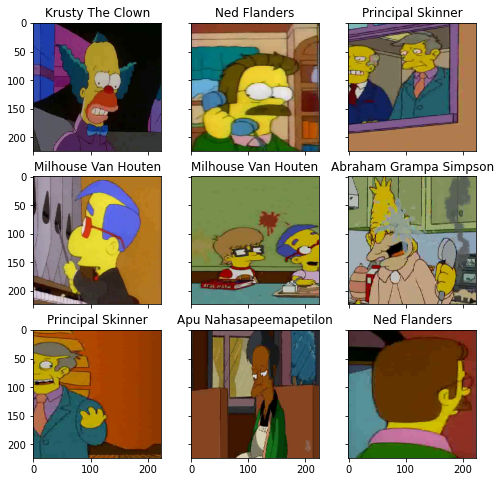

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8,8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Перейдем теперь к самой нейросети. Я экспериментировал с transfer learning, но достойных результатов не достиг, зато с сеткой, написанной с нуля, дела обстоят иначе. Ничего сложного она из себя не прдеставляет -- повторяющиеся свертка, нелинейность, макспулинг (иногда еще батчнормы).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ModelCnn(nn.Module):  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):     
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)   

        x = F.interpolate(x, size=(6, 6), mode='bilinear')  # resize to the size expected by the linear unit
        x = x.view(x.size(0), 6 * 6 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

Напишем тренировочный цикл

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        # sched = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            best_acc = 0.0
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            if val_acc > best_acc:
              torch.save(model.state_dict(), 'best-model-parameters.pt')
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Наконец, обучим сеть! Стоит учитывать, что обучение происходит почти на всем датасете, и валидационная выборка очень мала, поэтому не стоит смотреть на метрику на ней. Это делалось для того, чтобы обучить модель на максимальном количестве данных для Kaggle.

In [ ]:
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model=model, epochs=30, batch_size=256)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


loss 1.6418524025516077


epoch:   3%|▎         | 1/30 [03:40<1:46:26, 220.22s/it]


Epoch 001 train_loss: 1.6419     val_loss 1.4681 train_acc 0.5542 val_acc 0.6008
loss 3.5429398837414654


epoch:   7%|▋         | 2/30 [07:21<1:42:59, 220.69s/it]


Epoch 002 train_loss: 3.5429     val_loss 2.8465 train_acc 0.1264 val_acc 0.1759
loss 2.9676443257115106


epoch:  10%|█         | 3/30 [11:01<1:39:19, 220.71s/it]


Epoch 003 train_loss: 2.9676     val_loss 2.7342 train_acc 0.1816 val_acc 0.2405
loss 2.7466832209717142


epoch:  13%|█▎        | 4/30 [14:42<1:35:34, 220.57s/it]


Epoch 004 train_loss: 2.7467     val_loss 2.3974 train_acc 0.2392 val_acc 0.3194
loss 2.31561556187543


epoch:  17%|█▋        | 5/30 [18:17<1:31:02, 218.49s/it]


Epoch 005 train_loss: 2.3156     val_loss 1.9412 train_acc 0.3540 val_acc 0.4477
loss 1.8582411381331356


epoch:  20%|██        | 6/30 [21:51<1:26:49, 217.06s/it]


Epoch 006 train_loss: 1.8582     val_loss 1.6153 train_acc 0.4764 val_acc 0.5380
loss 1.4596580795266412


epoch:  23%|██▎       | 7/30 [25:31<1:23:32, 217.95s/it]


Epoch 007 train_loss: 1.4597     val_loss 1.3112 train_acc 0.5797 val_acc 0.6188
loss 1.1415335502136836


epoch:  27%|██▋       | 8/30 [29:09<1:19:55, 217.99s/it]


Epoch 008 train_loss: 1.1415     val_loss 1.1885 train_acc 0.6655 val_acc 0.6549
loss 0.9166928306221962


epoch:  30%|███       | 9/30 [32:38<1:15:17, 215.10s/it]


Epoch 009 train_loss: 0.9167     val_loss 1.0521 train_acc 0.7272 val_acc 0.6968
loss 0.7495124475522474


epoch:  33%|███▎      | 10/30 [36:07<1:11:09, 213.45s/it]


Epoch 010 train_loss: 0.7495     val_loss 0.9489 train_acc 0.7751 val_acc 0.7205
loss 0.6200359931046312


epoch:  37%|███▋      | 11/30 [39:45<1:08:00, 214.76s/it]


Epoch 011 train_loss: 0.6200     val_loss 0.8542 train_acc 0.8106 val_acc 0.7452
loss 0.4942378191785379


epoch:  40%|████      | 12/30 [43:20<1:04:27, 214.83s/it]


Epoch 012 train_loss: 0.4942     val_loss 0.8306 train_acc 0.8509 val_acc 0.7785
loss 0.42788045413114806


epoch:  43%|████▎     | 13/30 [46:53<1:00:42, 214.29s/it]


Epoch 013 train_loss: 0.4279     val_loss 0.8177 train_acc 0.8660 val_acc 0.7804
loss 0.36507428132674913


epoch:  47%|████▋     | 14/30 [50:27<57:06, 214.14s/it]


Epoch 014 train_loss: 0.3651     val_loss 0.7895 train_acc 0.8860 val_acc 0.7823
loss 0.28760518912564625


epoch:  50%|█████     | 15/30 [53:59<53:22, 213.47s/it]


Epoch 015 train_loss: 0.2876     val_loss 0.7940 train_acc 0.9079 val_acc 0.8099
loss 0.2596834549172358


epoch:  53%|█████▎    | 16/30 [57:31<49:44, 213.20s/it]


Epoch 016 train_loss: 0.2597     val_loss 0.8127 train_acc 0.9166 val_acc 0.7985
loss 0.23201480279253286


epoch:  57%|█████▋    | 17/30 [1:01:04<46:08, 212.99s/it]


Epoch 017 train_loss: 0.2320     val_loss 0.8835 train_acc 0.9254 val_acc 0.7947
loss 0.19888581013814968


epoch:  60%|██████    | 18/30 [1:04:31<42:16, 211.38s/it]


Epoch 018 train_loss: 0.1989     val_loss 0.8975 train_acc 0.9345 val_acc 0.7975
loss 0.18174268754029815


epoch:  63%|██████▎   | 19/30 [1:08:01<38:38, 210.76s/it]


Epoch 019 train_loss: 0.1817     val_loss 0.8397 train_acc 0.9412 val_acc 0.8270
loss 0.15610159307040952


epoch:  67%|██████▋   | 20/30 [1:11:34<35:15, 211.56s/it]


Epoch 020 train_loss: 0.1561     val_loss 0.9052 train_acc 0.9492 val_acc 0.8165
loss 0.1503118375654925


epoch:  70%|███████   | 21/30 [1:15:12<32:00, 213.37s/it]


Epoch 021 train_loss: 0.1503     val_loss 1.0200 train_acc 0.9520 val_acc 0.8241
loss 0.16304122931747275


epoch:  73%|███████▎  | 22/30 [1:18:47<28:32, 214.04s/it]


Epoch 022 train_loss: 0.1630     val_loss 0.8913 train_acc 0.9463 val_acc 0.8222
loss 0.10208350322632627


epoch:  77%|███████▋  | 23/30 [1:22:22<24:58, 214.14s/it]


Epoch 023 train_loss: 0.1021     val_loss 0.9384 train_acc 0.9663 val_acc 0.8260
loss 0.09872905901548537


epoch:  80%|████████  | 24/30 [1:25:55<21:24, 214.02s/it]


Epoch 024 train_loss: 0.0987     val_loss 0.9497 train_acc 0.9676 val_acc 0.8317
loss 0.09358803536319597


epoch:  83%|████████▎ | 25/30 [1:29:30<17:50, 214.09s/it]


Epoch 025 train_loss: 0.0936     val_loss 0.9681 train_acc 0.9706 val_acc 0.8203
loss 0.09970543618229302


epoch:  87%|████████▋ | 26/30 [1:33:05<14:17, 214.29s/it]


Epoch 026 train_loss: 0.0997     val_loss 0.9793 train_acc 0.9688 val_acc 0.8298
loss 0.09156494380228898


epoch:  90%|█████████ | 27/30 [1:36:41<10:44, 214.98s/it]


Epoch 027 train_loss: 0.0916     val_loss 0.9369 train_acc 0.9707 val_acc 0.8403
loss 0.09153870783153582


epoch:  93%|█████████▎| 28/30 [1:40:11<07:06, 213.42s/it]


Epoch 028 train_loss: 0.0915     val_loss 0.9866 train_acc 0.9701 val_acc 0.8365
loss 0.08370843101081184


epoch:  97%|█████████▋| 29/30 [1:43:36<03:30, 210.93s/it]


Epoch 029 train_loss: 0.0837     val_loss 0.9325 train_acc 0.9741 val_acc 0.8413
loss 0.06722039825663986


epoch: 100%|██████████| 30/30 [1:47:11<00:00, 214.39s/it]


Epoch 030 train_loss: 0.0672     val_loss 0.9257 train_acc 0.9796 val_acc 0.8479


Сделаем предсказания

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

0.85

На Kaggle получили следующий результат:
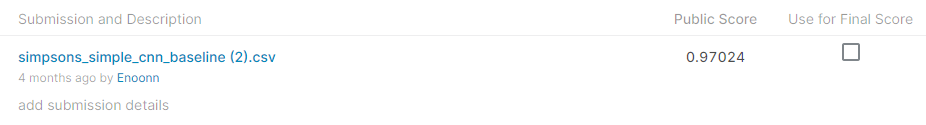

Визуализируем предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


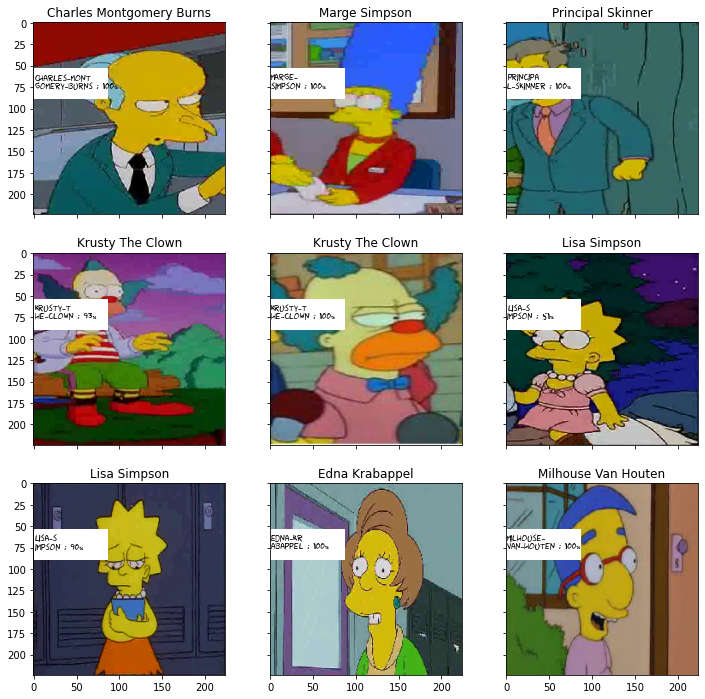

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Видим, что модель справляется весьма неплохо!

Создадим сабмит на Каггл

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)